In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.special import gammaln
import math
from matplotlib.scale import FuncScale


import sys
sys.path.append('../../')

from LRM.plotting import set_plot_style
from LRM.CMP import SmoothedEmpiricalDensity, CMP

set_plot_style()

In [4]:
def sample_com_poisson(lam, nu, size=1000, seed=1):
    """
    Sample from Conway-Maxwell-Poisson using rejection sampling.
    Assumes fixed lambda (lam) and nu.
    """
    def compute_Z(lam, nu, k_max=100):
        """
        Compute the normalizing constant Z(λ, ν) by truncating the infinite sum.
        """
        k = np.arange(0, k_max + 1)
        log_terms = k * np.log(lam) - nu * gammaln(k + 1)
        Z = np.sum(np.exp(log_terms))
        return Z

    def com_poisson_pmf(k, lam, nu, normalize=False, k_max=100):
        if normalize:
            Z = compute_Z(lam, nu, k_max)
        else:
            Z=1
            
        log_pmf = k * np.log(lam) - nu * gammaln(k + 1) - np.log(Z)
        return np.exp(log_pmf)
    
    np.random.seed(seed)
    
    samples = []
    # Use Poisson as proposal distribution with same lambda
    proposal = np.random.poisson(lam, size * 10)

    # Compute (unnormalized) PMFs
    max_k = np.max(proposal)
    pmf_vals = np.array([com_poisson_pmf(k, lam, nu) for k in range(max_k + 1)])
    M = np.max(pmf_vals / (np.exp(-lam) * lam**np.arange(max_k + 1) / np.exp(gammaln(np.arange(max_k + 1) + 1))))

    for k in proposal:
        p = com_poisson_pmf(k, lam, nu)
        q = np.exp(-lam) * lam**k / np.exp(gammaln(k + 1))  # Poisson PMF
        if np.random.rand() < (p / (M * q)):
            samples.append(k)
            if len(samples) >= size:
                break

    return np.array(samples)


In [5]:
def transform_logtheta_theta(mu_X, Sigma_X):

    mu1, mu2 = mu_X.flatten()
    sigma11, sigma12 = Sigma_X[0, 0], Sigma_X[0, 1]
    sigma22 = Sigma_X[1, 1]

    # Compute E[theta1] = E[exp(x1)]
    E_theta1 = np.exp(mu1 + 0.5 * sigma11)

    # Mean vector
    mu_Y = np.array([
        E_theta1,
        mu2
    ])

    # Variance of exp(x1)
    var_theta1 = (np.exp(sigma11) - 1) * np.exp(2 * mu1 + sigma11)

    # Covariance between exp(x1) and x2
    cov_theta1_theta2 = np.exp(mu1 + 0.5 * sigma11) * sigma12

    # Covariance matrix
    Sigma_Y = np.array([
        [var_theta1,             cov_theta1_theta2],
        [cov_theta1_theta2,      sigma22]
    ])

    return mu_Y.reshape(-1,1), Sigma_Y


def transform_theta_logtheta(mu_X, Sigma_X):

    mu_X = np.asarray(mu_X)
    Sigma_X = np.asarray(Sigma_X)

    theta1, theta2 = mu_X
    if theta1 <= 0:
        raise ValueError("theta1 must be positive for log transformation.")

    # g(mu_X)
    mu_Y = np.array([np.log(theta1), theta2])

    # Jacobian of g at mu_X
    J = np.array([
        [1/theta1, 0],
        [0,        1]
    ])

    # Covariance after transformation
    Sigma_Y = J @ Sigma_X @ J.T

    return mu_Y.reshape(-1,1), Sigma_Y

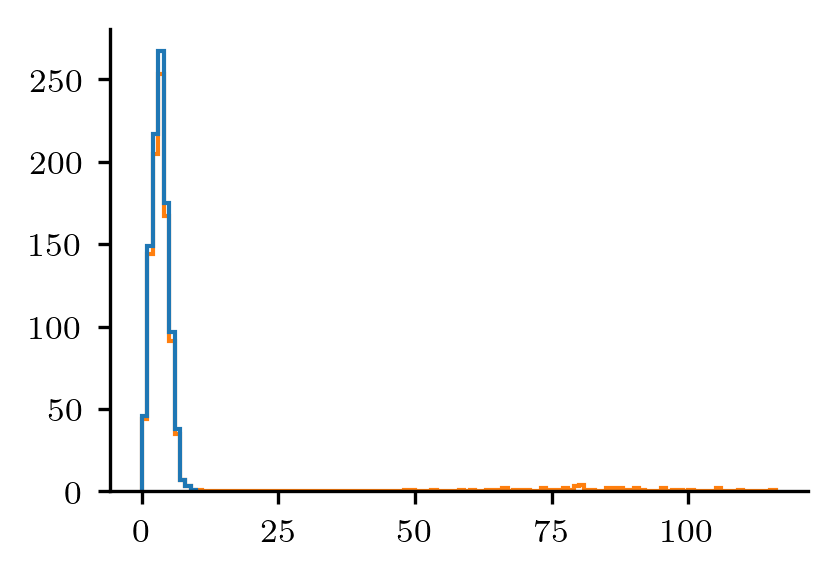

In [6]:
np.random.seed(43)
true_lam, true_nu = 4, 1.25
data = sample_com_poisson(lam=true_lam, nu=true_nu, size=1000, seed=42).reshape(-1,1)

idx = np.random.choice(a=len(data), size=50, replace=False)

data_contaminated = data.copy()
data_contaminated[idx] = np.random.poisson(lam=np.linspace(60, 100, len(idx)), size=(len(idx))).reshape(-1,1)

plt.figure(figsize=(3,2))
plt.hist(data, bins='auto', histtype='step', zorder=1)
plt.hist(data_contaminated, bins='auto', histtype='step', alpha=1, zorder=0);

In [7]:
def get_marginals(data, robust=False, beta=1.0, alpha=0.1):
    empirical = SmoothedEmpiricalDensity(alpha=alpha)
    empirical.fit(data)

    cmp = CMP(d=1, empirical=empirical, j_vals=[1], circular=False, robust=robust)

    mu_prior = np.ones((2,1))
    Sigma_prior = np.eye(2)
    posterior = cmp.posterior(data=data, beta=beta, mu_prior=mu_prior, Sigma_prior=Sigma_prior)

    mu, cov = transform_logtheta_theta(posterior.mean, posterior.cov)

    marginals = [norm(loc=mu[i], scale=np.sqrt(cov[i, i])) for i in range(len(mu))]

    return marginals

In [8]:
empirical = SmoothedEmpiricalDensity(alpha=0.0)
empirical.fit(data_contaminated)
cmp = CMP(d=1, empirical=empirical, j_vals=[1], circular=False, robust=False)

In [9]:
cmp.compute_divergence(data_contaminated, params=np.array([true_lam, true_nu]))

(array([6340.48156035]), 21)

In [10]:
def cmp_mean(nu, lambda_):
    return sum(k * (lambda_**k / math.factorial(k)**nu) for k in range(100)) / sum(lambda_**k / math.factorial(k)**nu for k in range(100))


epsilon = 0.01
def forward(x): return np.log(epsilon + x)
def inverse(x): return np.exp(x) - epsilon

Regular (lam, nu) :  [1.54382154] [0.47985707]
Robust (lam, nu) :  [4.07768738] [1.26462552]
Approx. CMP mean (LRM) :  [3.08434765]
Approx. CMP mean (LRM robust) :  [2.92607293]
[ True]


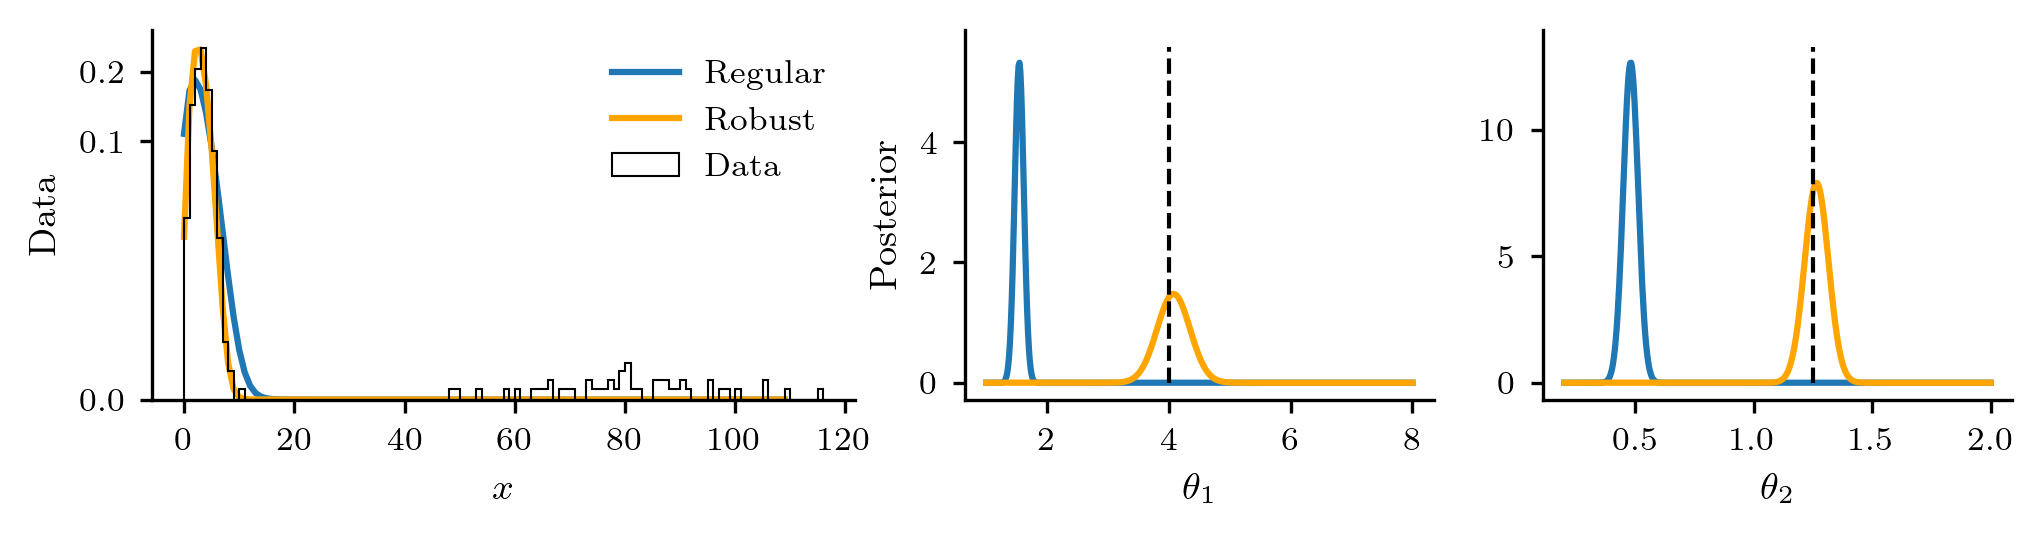

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(8, 1.6), gridspec_kw={"width_ratios": [1.5,1,1]})

beta_no_IMQ = 1.
beta_IMQ = 10.
alpha = 0.0

axs[0].set_ylabel("Data")
axs[0].set_xlabel(r"$x$")


axs[1].set_ylabel("Posterior")
axs[1].set_xlabel(r"$\theta_1$")
axs[2].set_xlabel(r"$\theta_2$")

x_range = [np.linspace(1., 8, 500), np.linspace(0.2, 2, 500)]

imq_range = np.linspace(0, 10, 1000)

marginals = get_marginals(data=data_contaminated, robust=False, beta=beta_no_IMQ, alpha=alpha)
marginals_robust = get_marginals(data=data_contaminated, robust=True, beta=beta_IMQ, alpha=alpha)

colors = ["tab:blue","orange"]

ks = np.arange(110)
for lambda_, nu, label, color in [(marginals[0].mean(), marginals[1].mean(), "Regular", colors[0]), (marginals_robust[0].mean(), marginals_robust[1].mean(), "Robust", colors[1])]:
    
    pmf = np.array([lambda_**k / math.factorial(k)**nu for k in ks]) 
    pmf /= pmf.sum()
    axs[0].plot(ks, pmf, linewidth=1.5, label=label, color=color);

axs[0].hist(data_contaminated, density=True, bins='auto', histtype='step', linewidth=0.5, color='black', label='Data');
axs[0].set_yscale(FuncScale(axs[0], functions=(forward, inverse)))




for i in range(1, 3):
    dist = marginals[i-1]
    dist_robust = marginals_robust[i-1]

    axs[i].plot(x_range[i-1], dist.pdf(x_range[i-1]), label='Regular', color=colors[0])
    axs[i].plot(x_range[i-1], dist_robust.pdf(x_range[i-1]), label="Robust", color=colors[1])


ymin, ymax = axs[1].get_ylim()
ymin = 0
axs[1].vlines(true_lam, ymin, ymax, color='black', linestyle='--', linewidth=1)

ymin, ymax = axs[2].get_ylim()
ymin = 0
axs[2].vlines(true_nu, ymin, ymax, color='black', linestyle='--', linewidth=1)


axs[0].legend(frameon=False)

print("Regular (lam, nu) : ", marginals[0].mean(), marginals[1].mean())
print("Robust (lam, nu) : ", marginals_robust[0].mean(), marginals_robust[1].mean())

print("Approx. CMP mean (LRM) : ", cmp_mean(nu=marginals[1].mean(), lambda_=marginals[0].mean()))
print("Approx. CMP mean (LRM robust) : ", cmp_mean(nu=marginals_robust[1].mean(), lambda_=marginals_robust[0].mean()))
print(cmp_mean(nu=marginals_robust[1].mean(), lambda_=marginals_robust[0].mean()) < cmp_mean(nu=marginals[1].mean(), lambda_=marginals[0].mean()))


#plt.savefig("./results/CMP-robust.pdf", format="pdf", bbox_inches='tight')